<a href="https://colab.research.google.com/github/MichelNivard/3-causal-sem-models/blob/main/Identification_of_causal_effects_through_heteroskedasticity_in_a_multi_group_SEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identification through heterokedasticity in a multi-group SEM

This is an interactive ilustration (an `R` notebook) of a model that is part of a [github repo](https://github.com/MichelNivard/3-causal-sem-models) and pre-print on three ways to perform causal inference in psychological sciences. Each of these identifies **(cyclical) networks** and **latent variable** models and allows for their direct emperical comparison. if you click "open in colab" the page will open in google colab and you can run chunks or change settings to get a feel for the model.

Please begin by reading the repo and pre-print as this notebook is not meant for consumption without context.

In the model below we identify a causal network trough mult-group SEM. In the multi group SEM we constrain error and confounding in a way that allows us to estimate a (cyclical) network that is identical across groups.

First we load some pacakges, and this might take a while if you run the notebook yourself on google colab (its free!). Go make some tea, grab lunch etc when this first chunk is doing its thing, all other chunks run in seconds.

In [1]:
install.packages("lavaan")
install.packages("qgraph")
library(lavaan)
library(qgraph)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘mnormt’, ‘pbivnorm’, ‘numDeriv’, ‘quadprog’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘checkmate’, ‘htmlwidgets’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’, ‘Rcpp’, ‘psych’, ‘plyr’, ‘Hmisc’, ‘igraph’, ‘jpeg’, ‘png’, ‘corpcor’, ‘reshape2’, ‘glasso’, ‘fdrtool’, ‘gtools’, ‘pbapply’, ‘abind’


This is lavaan 0.6-15
lavaan is FREE software! Please report any bugs.



## Simulations

Having loaded the required packages we'll simulate some data. Data simulation allows us to created faux data where te true model/process in known and illustrate how this technique retrieves the network as simulated base donly on cross sectional data.

We simulate a cyclical network between 5 vriables in 10 groups, each group has a sample size of 5000 and in each group we redraw new exogeneous variance in the 5 endogeneous variables (variables of interest). These differencesin exogeneous influences are what identify the network.

we add a confounder (`fc`) that influences all variables and per variable additional measurement error. 

We simulate a network structure (the same one we use in the paper), that gives rise to 5 correlated variables, the correlations between these variables are relatively homogeneous (between 0.52 and 0.65) and if these where psychometric tests people could very reasonably impose or assume a latent variable model where one unobserved factor causes the correlated responses on the five variables. 


In [2]:
set.seed(123)


n = 5000
groups = 10

b <- matrix(c(   0,  .22,   0,  .24,  .35, 
                 0,   0,   .15,  .31,  .0,
                 .35,  .2,   0, -.14,   .3,
                 .14, -.2,  .36,   0,   .4,
                 0, .30, .15,   -.15,    0), 5,5,byrow=T)



for(i in 1:groups){
  
  if(i == 1){
    
    
    r1 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    r2 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    r3 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    r4 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    r5 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    
    
    x <- cbind(r1,r2,r3,r4,r5)
    data <- cbind(i,t(solve(diag(ncol(b))-b) %*% t(x)))
    
  }
  if(i != 1){
    
    
    
    r1 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    r2 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    r3 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    r4 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    r5 <- rnorm(n,mean = 0,sd = runif(1,min = .8,max = 1.3))
    
    
    
    x <- cbind(r1,r2,r3,r4,r5)
    temp <- cbind(i,t(solve(diag(ncol(b))-b) %*% t(x)))
    data <- rbind(data,temp)
    
    
  }
  
}

fc <-  rnorm(n*groups)
data[,2] <-  data[,2] +  rnorm(n*groups) + fc
data[,3] <-  data[,3] +  rnorm(n*groups) + fc
data[,4] <-  data[,4] +  rnorm(n*groups) + fc
data[,5] <-  data[,5] +  rnorm(n*groups) + fc
data[,6] <-  data[,6] +  rnorm(n*groups) + fc

colnames(data) <- c("group","y1","y2","y3","y4","y5") 
data <- as.data.frame(data)




Lets inspect the simulated network:

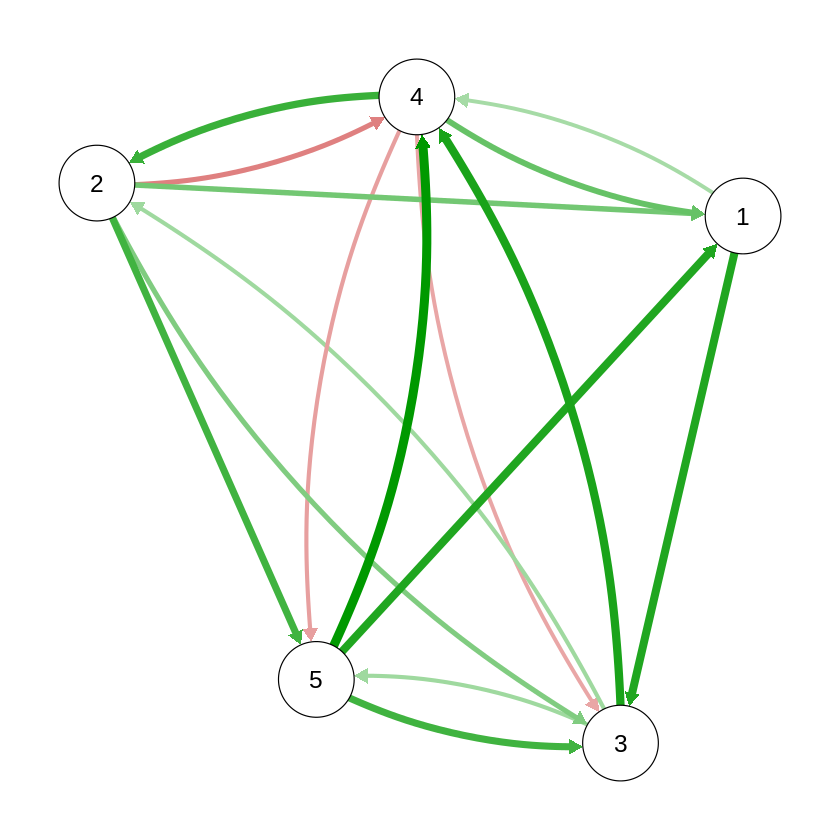

In [3]:
# plot b as a network, note the transpose because qgraph is different then lavaan.
qgraph(t(b))

## Fitting a multi group network SEM.

Now we first fit the basic multi group model. In this model we fix the regresisons of the endogeneous variables on eahother across groups.


First we define the model in the lavaan SEM syntax (if you aren't familiar see [here](https://lavaan.ugent.be/tutorial/syntax1.html) for details).

briefly like in other R formula's `~` represents a regression relation, while `=~` r`epresents a factor loading and `~~` represents a (co)variance.

Latameters that are explicity labeled are constrained across groups (like `l1*`) as are further parameters in the `sem()` function call.

In the `sem()` function call we also indicate which variable defines group membership.



In [4]:
model.rigo <- "
  
  fc  =~ l1*y1 + l2*y2 + l3*y3 + l4*y4 + l5*y5
  f1 =~ y1
  f2 =~ y2
  f3 =~ y3
  f4 =~ y4
  f5 =~ y5
  
  fc ~~ 1*fc
  
  y1 ~~ a*y1
  y2 ~~ b*y2
  y3 ~~ c*y3
  y4 ~~ d*y4
  y5 ~~ e*y5

  
f1 ~ f2 + f3 + f4 + f5
f2 ~ f1 + f3 + f4 + f5
f3 ~ f1 + f2 + f4 + f5
f4 ~ f1 + f2 + f3 + f5
f5 ~ f1 + f2 + f3 + f4
"

model.fit.rigo <- sem(model = model.rigo,data = data,group = "group",group.equal = c("regressions","loadings"),orthogonal.y = T,orthogonal.x =T)




To confirm the model worked lets compare the simulated and estimated network edges:

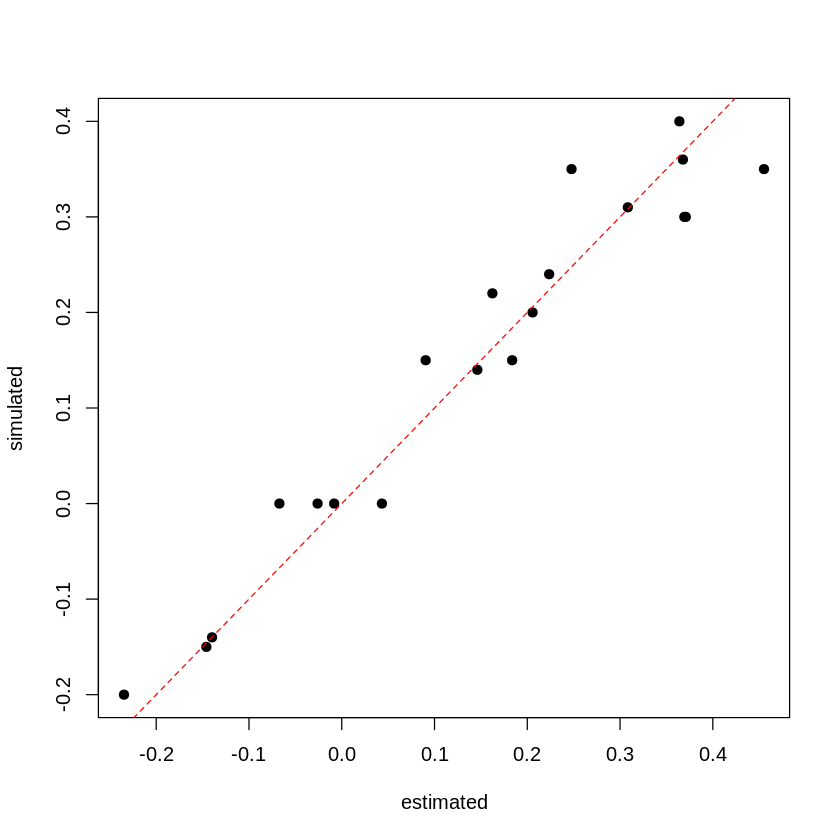

In [5]:
estimated <- model.fit.rigo@ParTable$est[model.fit.rigo@ParTable$op == "~"][1:20]
c <- b # get true network
diag(c) <- NA # omit diag
simulated <- na.omit(as.vector(t(c))) # vectorize

plot(estimated,simulated,pch=19) # plot treu vs estimated paths
abline(0,1,col="red",lty="dashed")

# relaxing assumptions somewhat

It might not be reasonable to constrain error and confounding to be equal across all groups, but if you have sufficient groups, specific (ideally theory driven!) allowences can be made.

To illustrate, I (somewhat arbitrarially) release certain factor loadings and error variances. 

A more systematic strategy would be to use known within group test-restest correlations for indicators to proxy for measurement error and to define per group scaling factors for the error based on these. 

In [6]:
model.rigo.relax <- "
  
  fc  =~ l1*y1 + l2*y2 + l3*y3 + c(l4,l4,l4,l4,l4,l4,l4,l4_8,l4_9,l4_10)*y4 + l5*y5
  f1 =~ y1
  f2 =~ y2
  f3 =~ y3
  f4 =~ y4
  f5 =~ y5
  
  fc ~~ 1*fc
  
  y1 ~~ a*y1
  y2 ~~ b*y2
  y3 ~~ c(c1,c2,c3,c,c,c,c,c,c,c)*y3
  y4 ~~ d*y4
  y5 ~~ e*y5

  
f1 ~ f2 + f3 + f4 + f5
f2 ~ f1 + f3 + f4 + f5
f3 ~ f1 + f2 + f4 + f5
f4 ~ f1 + f2 + f3 + f5
f5 ~ f1 + f2 + f3 + f4
"

model.fit.rigo.relax <- sem(model = model.rigo.relax,data = data,group = "group",group.equal = c("regressions","loadings"),orthogonal.y = T,orthogonal.x =T)


We again compere the true and simualted rtesults and see pretty decent retrieval.

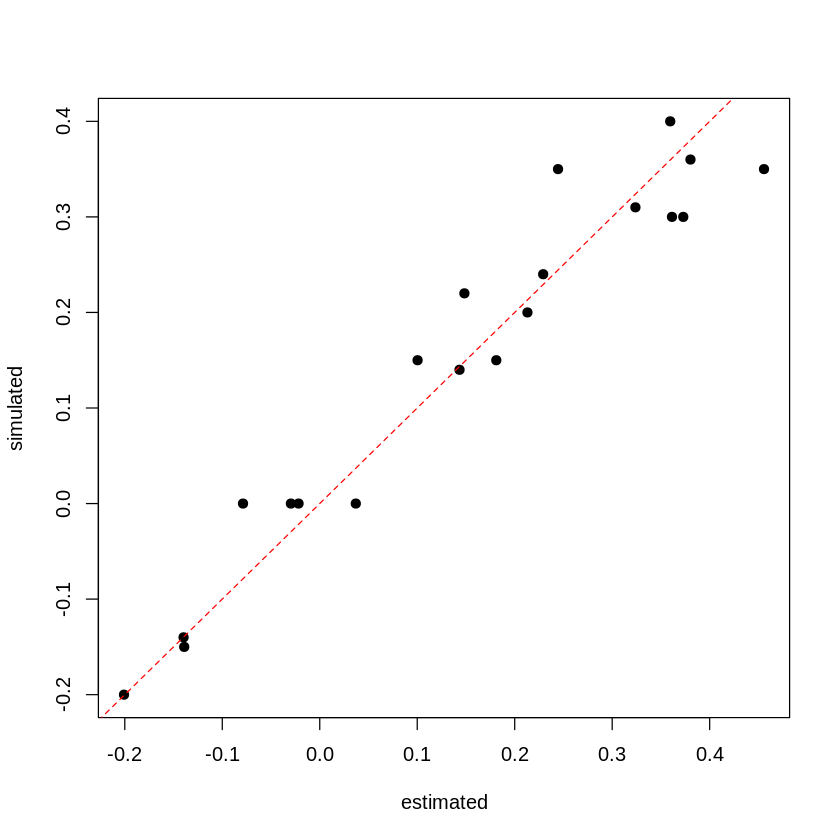

In [7]:
estimated <- model.fit.rigo.relax@ParTable$est[model.fit.rigo.relax@ParTable$op == "~"][1:20]
c <- b # get true network
diag(c) <- NA # omit diag
simulated <- na.omit(as.vector(t(c))) # vectorize

plot(estimated,simulated,pch=19) # plot treu vs estimated paths
abline(0,1,col="red",lty="dashed")

## relaxing the network?

You can even relax constraints of specific network paths to allow for heterogeneity between (but not within) groups. Obviously here illustrated in a very naive way by releasing the f5 ~ f4 path for 2 random groups.

In emperical applications you'd always prefer to relax and retain paths based on theory, or to explicitly test theory (e.g. if you have all groups split across gender, age, etc you might consider gender and age specific networks).

In [8]:
model.rigo.relax.further <- "
  
  fc  =~ l1*y1 + l2*y2 + l3*y3 + c(l4,l4,l4,l4,l4,l4,l4,l4_8,l4_9,l4_10)*y4 + l5*y5
  f1 =~ y1
  f2 =~ y2
  f3 =~ y3
  f4 =~ y4
  f5 =~ y5
  
  fc ~~ 1*fc
  
  y1 ~~ a*y1
  y2 ~~ b*y2
  y3 ~~ c(c1,c2,c3,c,c,c,c,c,c,c)*y3
  y4 ~~ d*y4
  y5 ~~ e*y5

  
f1 ~ f2 + f3 + f4 + f5
f2 ~ f1 + f3 + f4 + f5
f3 ~ f1 + f2 + f4 + f5
f4 ~ f1 + f2 + f3 + f5
f5 ~ f1 + f2 + f3 + c(b54,b54,b54,b54_g4,b54,b54,b54,b54,b54,b54_g10)*f4
"

model.fit.rigo.relax.further <- sem(model = model.rigo.relax.further,data = data,group = "group",group.equal = c("regressions","loadings"),orthogonal.y = T,orthogonal.x =T)


Warning message in lav_object_post_check(object):
“lavaan WARNING: some estimated lv variances are negative”


We again compare estimated to simualted and see reasonable concordance.

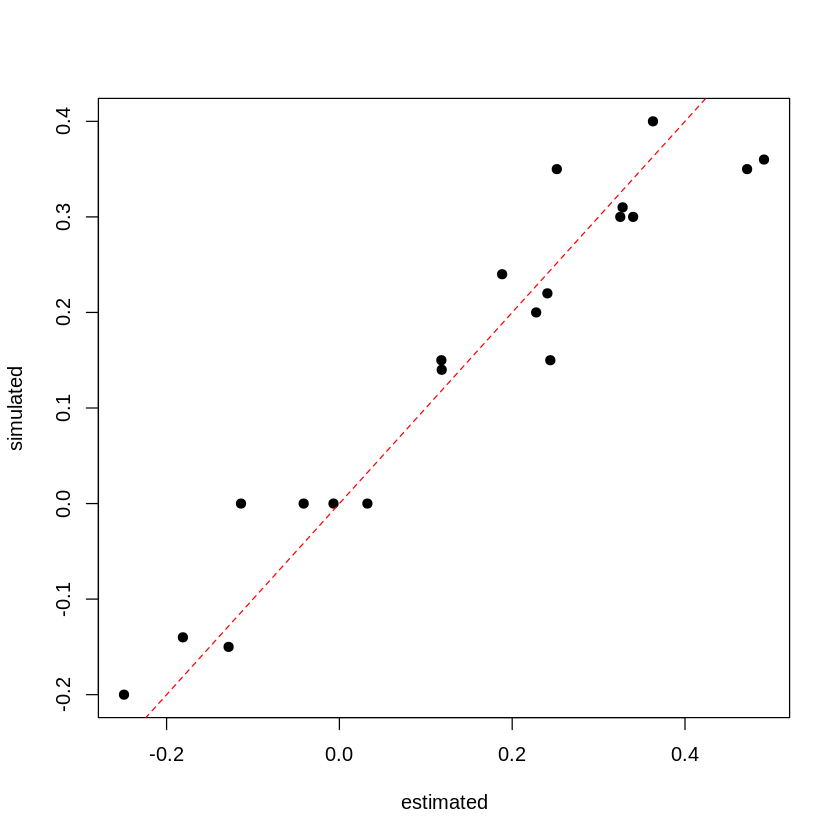

In [9]:
estimated <- model.fit.rigo.relax.further@ParTable$est[model.fit.rigo.relax.further@ParTable$op == "~"][1:20]
c <- b # get true network
diag(c) <- NA # omit diag
simulated <- na.omit(as.vector(t(c))) # vectorize

plot(estimated,simulated,pch=19) # plot treu vs estimated paths
abline(0,1,col="red",lty="dashed")